# Data Augmentation using Python "imgaug"

*imgaug* is a library for image augmentation in machine learning experiments. It supports a wide range of augmentation techniques, allows to easily combine these, has a simple yet powerful stochastic interface, can augment images and keypoints/landmarks on these and offers augmentation in background processes for improved performance.

![Example augmentations of a single input image](./example_grid.jpg)

Link: [imgaug library](http://imgaug.readthedocs.io/en/latest/index.html)

It can be used for:
* Artificially generate **more data** to our dataset.
* Make our model **more robust** to unseen examples.
* Compensate **unbalanced classes** in Machine Learning (only when there are <span style="color:red">** *small differences* **</span>)

Be carefull!
* Transformations must be **consistent** and **contextualized**

## Example 1. Single Image, Sequential Augmentation

In [1]:
import numpy as np
import imgaug.imgaug as ia
import matplotlib.pyplot as plt
from imgaug.imgaug import augmenters as iaa
import os

In [2]:
# load an image
image = ia.quokka(size=(256, 256))

** *Important!* ** The image dimensions must be one in the following 2 formats:

1. (nn, hh, ww, dd) or
2. (nn, hh, ww)*, 

where *nn* is the number of frames in a batch, *hh, ww* the height and width of the image and *dd* is the depth of the image

In [3]:
print image.shape

(256, 256, 3)


In [4]:
image = np.expand_dims(image, 0)
print image.shape

(1, 256, 256, 3)


In [5]:
# generate some landmarks in the image
landmarks = {}
landmarks['x'] = np.array([70, 95, 70, 95, 82, 82])
landmarks['y'] = np.array([75, 75, 100, 100, 50, 125])

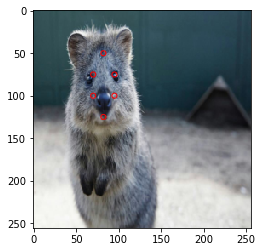

In [6]:
# show overlay landmarks and image to be augmented
ax = plt.gca()
ax.cla() # clear things for fresh plot
for i in range(landmarks['x'].size):
    circle = plt.Circle((landmarks['x'][i], landmarks['y'][i]), 3, color='red', fill=False)
    ax.add_artist(circle)
plt.imshow(image[0])
plt.show()

In [7]:
kp = [ia.Keypoint(x=landmarks['x'][i], y=landmarks['y'][i]) for i in range(landmarks['x'].size)]
keypoints = ia.KeypointsOnImage(kp, shape=image[0].shape)

In [8]:
seq = iaa.Sequential([
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect keypoints
    # rotate by exactly 10deg and scale to 50-70%, affects keypoints
    iaa.Affine(
        rotate=10,
        scale=(0.5, 0.7)
    ) 
])

In [9]:
# Make our sequence deterministic.
# We can now apply it to the image and then to the keypoints and it will
# lead to the same augmentations.
# IMPORTANT: Call this once PER BATCH, otherwise you will always get the
# exactly same augmentations for every batch!
seq_det = seq.to_deterministic()

In [10]:
# Augment keypoints and images.
# As we only have one image and list of keypoints, we use
# [image] and [keypoints] to turn both into lists (batches) for the
# functions and then [0] to reverse that. In a real experiment, your
# variables would likely already be lists.
image = list(image)
image_aug = seq_det.augment_images(image)[0]
# image_aug = seq_det.augment_images([image])[0]

keypoints_aug = seq_det.augment_keypoints([keypoints])[0]
print image_aug.shape

(256, 256, 3)


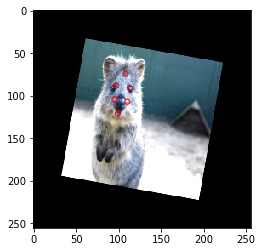

In [11]:
# Generate, save and preview final image
ax = plt.gca()
ax.cla() # clear things for fresh plot
for j in range(len(keypoints_aug.keypoints)):
    circle = plt.Circle((keypoints_aug.keypoints[j].x, keypoints_aug.keypoints[j].y), 3, color='red', fill=False)
    ax.add_artist(circle)

plt.imshow(image_aug)
plt.show()

## Example 2. Single Image, Random Augmentation

In [12]:
seq = iaa.Sequential([iaa.Fliplr(0.5), iaa.GaussianBlur((0, 3.0))])

In [13]:
seq.show_grid(image[0], cols=3, rows=3)

## Example 3. Batch of Images, Random Augmentation

In [14]:
# The array has shape (batch_size, 64, 64, 3) and dtype uint8.
batch_size = 16
images = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(batch_size)], dtype=np.uint8
)

In [15]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

In [16]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    sometimes(iaa.ContrastNormalization((0.75, 1.5))),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

images_aug = seq.augment_images(images)

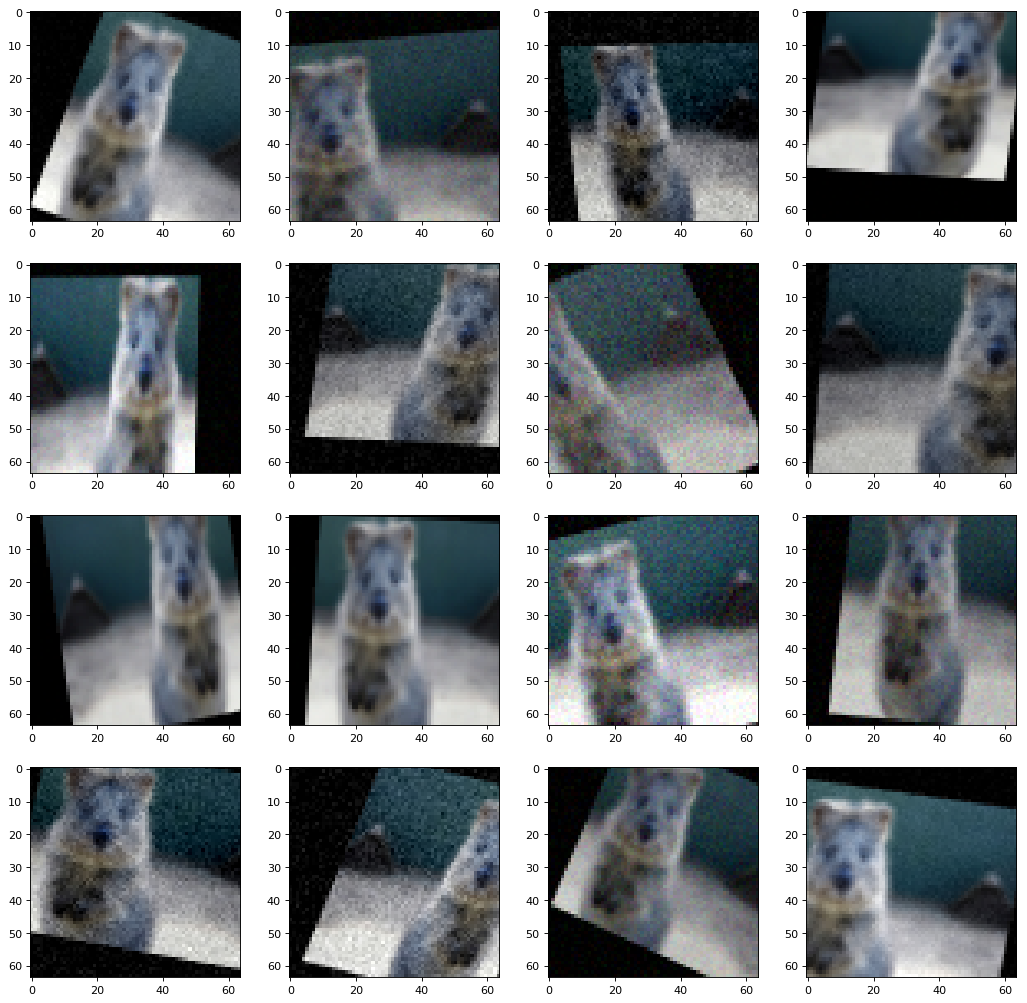

In [17]:
fig = plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')

for i in range(batch_size):
    plt.subplot(4,4,i+1)
    plt.imshow(images_aug[i])
    
plt.show()

## Example 4. Batch of Images, Random Augmentation Range

In [18]:
seq_template = iaa.Sequential(iaa.SomeOf(3, [
    iaa.Fliplr(0.5),  # horizontal flips
    # Drop 0 to 5% of all pixels by converting them to black pixels, but do that on a lower-resolution version of
    # the image that has 5% to 50% of the original size, leading to large rectangular areas being dropped:
    iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.25)),
    # Add gaussian noise
    iaa.AdditiveGaussianNoise(scale=(0.0, 0.05 * 255)),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2)),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them and rotate them .
    iaa.Affine(
        scale=(0.9, 1.1),
        translate_percent={"x": (-0.08, 0.08), "y": (-0.08, 0.08)},
        rotate=(-10, 10))

    ]), random_order=True)  # apply augmenters in random order

images_aug = seq_template.augment_images(images)

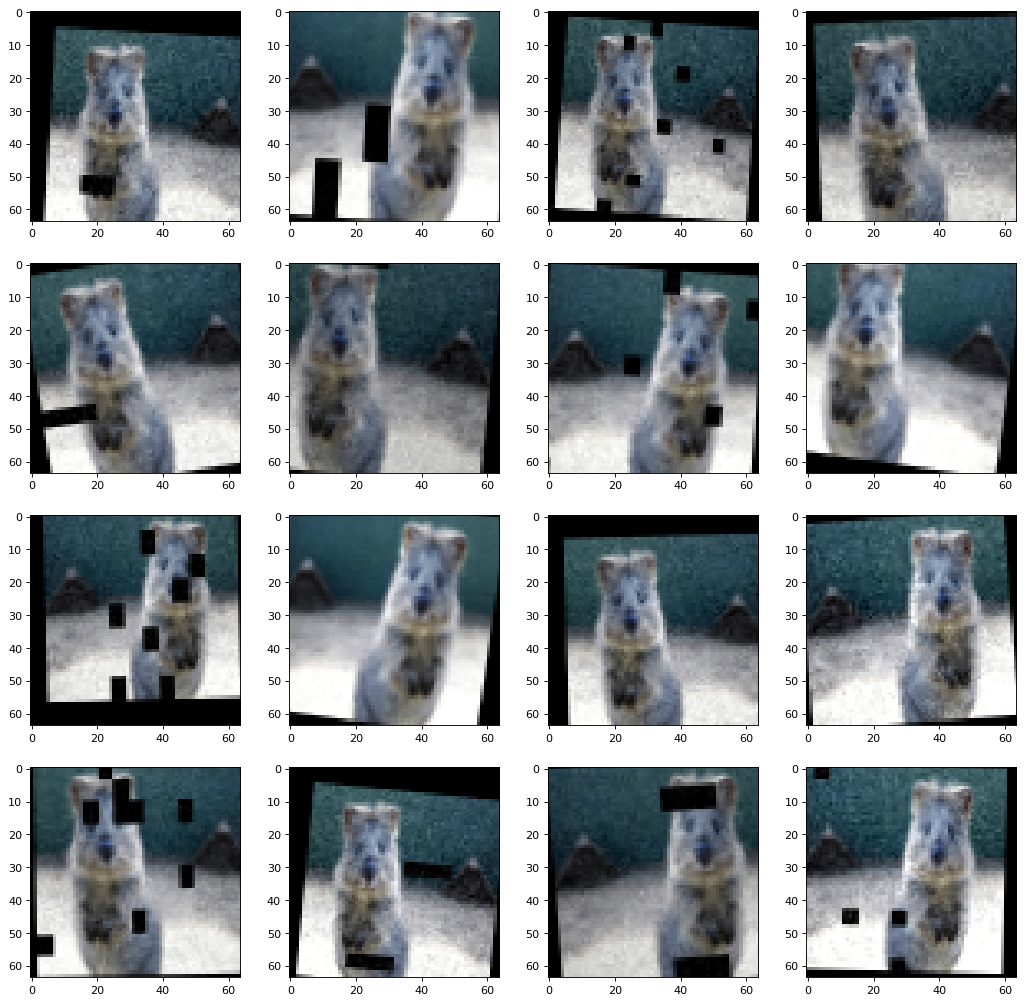

In [19]:
fig = plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')

for i in range(batch_size):
    plt.subplot(4,4,i+1)
    plt.imshow(images_aug[i])
    
plt.show()